# Small demo notebook for misclassification detection

In this notebook we will train some models on MRPC dataset and explore several popular methods for uncertainty estimation (UE) - MC dropout, Mahalanobis distance and HS-RAU. We will also cover some regularizers, that used to improve quality of UE. So let's start from importing necessary functions and training models.

Note that this is just a small demo - full code for training classification models could be found in run_glue.py, full code for regularizers - in ue4nlp/transformers_regularized.py, and full code for uncertainty estimation methods - in ue4nlp/ue_estimator_\*.py

## Training models

We will train [ELECTRA](https://arxiv.org/abs/2003.10555) model for text classification. But firstly we will import necessary functions. Also don't forget to install dependencies - it's located in ../requirements.txt.

In [1]:
import os
# import uncertainty estimators
from ue4nlp.ue_estimator_mc import UeEstimatorMc
from ue4nlp.ue_estimator_mahalanobis import UeEstimatorMahalanobis
from utils.plot_error_detection import get_score_ratio
from ue4nlp.ue_scores import sampled_max_prob
import matplotlib.pyplot as plt


from demo_utils import train_model, preproc_config, get_table, eval_model
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import open_dict, OmegaConf
import torch
import numpy as np
from IPython.display import clear_output
import pandas as pd
import json
from pathlib import Path
# if use cuda
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.set_device(0)
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

/home/jovyan/new_ue_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To simplify process of setting training parameters, we load predefined config. We will use Hydra configs in this notebook - basically, it's a modification of python dicts, that could be used for storing experiments parameters. More info about Hydra configs could be found [here](https://hydra.cc/).

In [2]:
# Let's set model params with config
# We will use MRPC dataset
configs_dir = "../configs"
config_path = "mrpc"
abs_config_dir=os.path.abspath(configs_dir)
with initialize_config_dir(config_dir=abs_config_dir):
    config = compose(config_name=config_path)

Modify config a little before training.

In [3]:
# Set config only to train and train model
config.do_train = True
config.do_eval = True
config.do_ue_estimate = False
config.data.validation_subsample = 0.0
# set dir for saving model and results
with open_dict(config):
    config.model_dir = '../workdir/model/'
# preprocess config - update pathes for saving
config, _, _ = preproc_config(config, init=True)
# seeds
seeds = [42, 4519, 941]

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Let's look that inside our config. For better readability we will transform it to yaml

In [4]:
print(OmegaConf.to_yaml(config))

training:
  learning_rate: 5.0e-05
  per_device_eval_batch_size: 1000
  per_device_train_batch_size: 16
  num_train_epochs: 4
  warmup_ratio: 0.1
  seed: 101
ue:
  ue_type: mc-dpp
  dropout_type: DPP
  inference_prob: 0.1
  committee_size: 20
  dropout_subs: last
  use_cache: true
  eval_passes: false
  calibrate: true
  use_selective: false
  lamb: 0.01
  reg_type: reg-curr
  dropout:
    max_n: 100
    max_frac: 0.4
    mask_name: ht_dpp
    dry_run_dataset: eval
    is_reused_mask: true
    mask_name_for_mask: rbf
    committee_size: 20
    use_ood_sampling: false
    ood_sampling:
      dataset_name: imdb
      subset: test
      number_of_samples: 5000
model:
  model_name_or_path: google/electra-base-discriminator
data:
  task_name: mrpc
  subsample_perc: 0.0
  max_seq_length: 128
  validation_subsample: 0.0
  validation_seed: 42
spectralnorm_layer: last
cache_dir: /home/jovyan/uncertainty-estimation/workdir/cache
output_dir: /home/jovyan/uncertainty-estimation/workdir/results/mrp

So inside our config we have training and data parameters, some common parameters like saving dirs, and parameters for uncertainty estimation.

Now we are ready for training models. We will train several models with different seeds and with different regularizers, so we could obtain mean values for each experiment.

### Models without regularization

In [5]:
# set the model postfix, to save models with different regularizers to separate folders
with open_dict(config):
    config.model_postfix = 'raw'
    config.ue.use_selective = False
    config.ue.reg_type = 'raw'
    # set optimal params for this model
    config.training.num_train_epochs = 12
    config.training.learning_rate = 5e-05
    config.training.per_device_train_batch_size = 32
    config.training.weight_decay = 0.1
for seed in seeds:
    config.seed = seed
    train_model(config)
    clear_output()

### Models with [Confident Error Regularizer](https://aclanthology.org/2021.acl-long.84/) (CER)

In [6]:
with open_dict(config):
    config.model_postfix = 'cer'
    # also set parameters for regularization
    config.ue.use_selective = True
    config.ue.reg_type = 'reg-curr'
    # set optimal params for this model
    config.training.num_train_epochs = 7
    config.training.learning_rate = 5e-05
    config.training.per_device_train_batch_size = 16
    config.training.weight_decay = 0.01
    config.ue.lamb = 0.2
for seed in seeds:
    config.seed = seed
    train_model(config)
    clear_output()

### Models with [Metric Regularizer](https://aclanthology.org/N19-1316/) (metric)

In [7]:
with open_dict(config):
    config.model_postfix = 'metric'
    # also set parameters for regularization
    config.ue.use_selective = True
    config.ue.reg_type = 'metric'
    # set optimal params for this model
    config.training.num_train_epochs = 11
    config.training.learning_rate = 3e-05
    config.training.per_device_train_batch_size = 32
    config.training.weight_decay = 0.1
    config.ue.lamb = 1.0
    config.ue.lamb_intra = 0.01
    config.ue.margin = 0.1
for seed in seeds:
    config.seed = seed
    train_model(config)
    clear_output()

### Models with [Rebalanced Accuracy-Uncertainty loss](https://arxiv.org/pdf/2203.09278.pdf) (HS-RAU)

In [8]:
with open_dict(config):
    config.model_postfix = 'rau'
    # also set parameters for regularization
    config.ue.use_selective = True
    config.ue.reg_type = 'rau'
    # set optimal params for this model
    config.training.num_train_epochs = 5
    config.training.learning_rate = 2e-05
    config.training.per_device_train_batch_size = 4
    config.training.weight_decay = 0.0
    config.ue.lamb = 0.005
    config.ue.unc_threshold = 0.4
    config.use_hs_labels = True
for seed in seeds:
    config.seed = seed
    train_model(config)
    clear_output()

## Calculating UE

By now, we've trained several models on the MRPC dataset. So now we look at some methods of uncertainty estimation - [MC dropout on all layers](https://proceedings.mlr.press/v48/gal16.html) (MC) and [Mahalanobis distance](https://ojs.aaai.org/index.php/AAAI/article/view/17612) (MD).

In [9]:
# Now we have trained model, let's use it and get uncertainty estimation scores
# Set config to UE
config.do_train = False
config.do_eval = True
config.do_ue_estimate = True
with open_dict(config):
    config.use_hs_labels = False

At first, create main function for uncertainty estimation. In this function we simply create estimator and call it.

In [10]:
def create_ue_estimator(
    model,
    ue_args,
    eval_metric,
    calibration_dataset,
    train_dataset,
    cache_dir,
    config=None,
):
    if ue_args.ue_type == "mc" or ue_args.ue_type == "mc-dc":
        return UeEstimatorMc(
            model, ue_args, eval_metric, calibration_dataset, train_dataset
        )
    elif ue_args.ue_type == "maha":
        return UeEstimatorMahalanobis(model, ue_args, config, train_dataset)
    else:
        raise ValueError()


def estimate(
    config,
    classifier,
    eval_metric,
    calibration_dataset,
    train_dataset,
    eval_dataset,
    eval_results,
    work_dir
):
    """Function for uncertainty estimation"""
    true_labels = eval_results["true_labels"]
    # create estimator
    ue_estimator = create_ue_estimator(
        classifier,
        config.ue,
        eval_metric,
        calibration_dataset=calibration_dataset,
        train_dataset=train_dataset,
        cache_dir=config.cache_dir,
        config=config,
    )
    # fit UE estimator
    ue_estimator.fit_ue(X=train_dataset, X_test=eval_dataset)
    # calc UE
    ue_results = ue_estimator(eval_dataset, true_labels)
    # save results
    eval_results.update(ue_results)
    with open(Path(work_dir) / "dev_inference.json", "w") as res:
        json.dump(eval_results, res)

### MC Dropout

Now we use estimators for each method. Let's start from MC dropout.\
We already imported estimator for this method - UeEstimatorMc, now we will use it to obtain uncertainty estimates.

Now we only have to modify our config and add to it parameters for MC dropout.

In [11]:
config, args_train, args_data = preproc_config(config)
config.ue.ue_type = 'mc'
config.ue.dropout_type = 'MC'
config.ue.inference_prob = 0.1
config.ue.committee_size = 20
config.ue.dropout_subs = 'all'
config.ue.use_cache = True
config.ue.eval_passes = False
config.ue.calibrate = False
config.ue.use_selective = False
# types of used regularizers
postfixes = ['raw', 'cer', 'metric', 'rau']
for seed in seeds:
    for model_postfix in postfixes:
        with open_dict(config):
            config.model_postfix = model_postfix
            config.seed = seed
            config.use_hs_labels = True if model_postfix == 'rau' else False
        # eval model
        classifier, eval_metric, calibration_dataset, train_dataset, eval_dataset, eval_results, work_dir = eval_model(config, 'mc', args_train, args_data)
        # after calc UE for model
        estimate(config, classifier, eval_metric, calibration_dataset, train_dataset, eval_dataset, eval_results, work_dir)
        clear_output()

### Mahalanobis Distance

We will use estimator for Mahalanobis distance, UeEstimatorMahalanobis.

Mahalanobis distance is a generalisation of the Euclidean distance, which takes into account the spreading of instances in the training set along various directions in a feature space. $u_{MD} = \min_{c \in C}(h_{i}-\mu_{c})^{T}\Sigma^{-1}(h_{i}-\mu_{c}),$\
where $h_{i}$ is a hidden representation of a $i$-th instance, $\mu_{c}$ is a centroid of a class $c$, and $\Sigma$ is a covariance matrix for hidden representations of training instances.

In [12]:
config, args_train, args_data = preproc_config(config)
config.ue.ue_type = 'maha'
config.ue.dropout_type = ''
config.ue.dropout_subs = ''
config.ue.use_cache = True
config.ue.eval_passes = False
config.ue.calibrate = False
config.ue.use_selective = False
# types of used regularizers
postfixes = ['raw', 'cer', 'metric', 'rau']
for seed in seeds:
    for model_postfix in postfixes:
        with open_dict(config):
            config.model_postfix = model_postfix
            config.seed = seed
            config.use_hs_labels = True if model_postfix == 'rau' else False
        # eval model
        classifier, eval_metric, calibration_dataset, train_dataset, eval_dataset, eval_results, work_dir = eval_model(config, 'maha', args_train, args_data)
        # after calc UE for model
        estimate(config, classifier, eval_metric, calibration_dataset, train_dataset, eval_dataset, eval_results, work_dir)
        clear_output()

## Results

We already trained models and calculated uncertainty estimates, it's time to look at results.

In [13]:
def to_table(results, name, return_baseline=False):
    """Small helper function for building tables."""
    replace_dict = {'bald': 'BALD',
                    'variance': 'PV',
                    'sampled_max_prob': 'SMP',
                    'mahalanobis_distance': 'MD',
                    'sampled_entropy': 'SE',
                    'var_ratio': 'VR'}
    table = pd.DataFrame().from_dict(results)
    scores = list(results[list(results.keys())[0]].index)
    scores = [replace_dict.get(score, score) for score in scores]
    table['UE Score'] = scores
    table['Method'] = [name] * len(table)
    table.drop('count', inplace=True)
    baseline = table.loc['baseline (max_prob)']
    baseline['Method'] = 'SR (baseline)'
    baseline['UE Score'] = 'MP'
    table.drop('baseline (max_prob)', inplace=True)
    if return_baseline:
        return table, baseline
    else:
        return table

Here we use several different scores for uncertainty estimation - BALD, probability variance (PV), maximum probability (MP) and sampled maximum probability (SMP).\
The most simple score is MP:\
$u_{SR}(x) = 1 - \max_{c \in C} p(y=c|x).$\
As $C$ in this equation denoted number of classes, and $p(y|x)$ is probability over classes.\
SMP score formulated as following:\
$u_{SMP} = 1 -  \max_{c \in C} \frac{1}{T}\sum_{t=1}^T  p_t^{c}.$\
For this and for all next scores we assume that we have conducted $T$ stochastic passes. In this equation $p_t^{c}$ is the probability of the class $c$ for the $t$-th stochastic forward pass.\
PV score:
$u_{PV} = \frac{1}{C} \sum_{c = 1}^C \left( \frac{1}{T - 1} \sum_{t = 1}^T {(p^c_t-\overline{p^c})^2} \right),$\
where $\overline{p^c}=\frac{1}{T} \sum_t{p^{c}_{t}}$ is the probability for a class $c$ averaged across $T$ stochastic forward passes.\
BALD score:\
$u_{B} = -\sum_{c = 1}^C \overline{p^c} \log \overline{p^c} +  \frac{1}{T}\sum_{c, t} p^{c}_{t}\log p^{c}_{t}.$

For evaluating quality of UE we will use reversed pair proportion [(RPP)](https://aclanthology.org/2021.acl-long.84/) and area under the risk-coverage curve [(RCC-AUC)](https://www.jmlr.org/papers/volume11/el-yaniv10a/el-yaniv10a.pdf) metrics.\
The risk coverage curve demonstrates the cumulative sum of loss due to misclassification (cumulative risk) depending on the uncertainty level used for rejection of predictions. The lower area under this curve indicates better quality of the UE method.\
RPP measures how far the uncertainty estimator $\tilde{u}$ is to ideal, given the labeled dataset of size $n$:

$RPP = \frac{1}{n^2} \displaystyle\sum_{i,j = 1}^n \mathbb{1}[\tilde{u}(x_i) > \tilde{u}(x_j), l_i > l_j].$

For both metrics,  $l$ is an indicator loss function.

In [14]:
# Here we calculate metrics for each regularizer and each method in for loop
for postfix in postfixes:
    # Firstly, let's set pathes to our results
    mc_path = os.path.join(config.output_dir, postfix, "mc")
    maha_path = os.path.join(config.output_dir, postfix, "maha")
    # We will calculate two metrics - RPP and RCC-AUC
    metrics = ['rpp', 'rcc-auc']
    mc_res = get_table(config, mc_path)
    maha_res = get_table(config, maha_path)
    mc_table, baseline = to_table(mc_res, 'MC', True)
    maha_table = to_table(maha_res, 'MD')
    table = pd.concat([mc_table, maha_table])
    table.loc['Baseline'] = baseline
    # Now make table more readable
    columns = ['Method', 'UE Score'] + metrics
    table = table[columns]
    table.reset_index(drop=True, inplace=True)
    print(f"Results for {postfix.upper()} regularization")
    print(table)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
PyTorch: set

Results for RAW regularization
          Method UE Score        rpp     rcc-auc
0             MC     BALD  2.59±0.16  22.65±0.80
1             MC      SMP  1.95±0.20  15.76±2.95
2             MC       PV  2.23±0.13  19.34±1.71
3             MD       MD  1.79±0.13  12.83±1.09
4  SR (baseline)       MP  2.22±0.47  18.51±5.97
Results for CER regularization
          Method UE Score        rpp     rcc-auc
0             MC     BALD  2.81±0.10  24.05±2.06
1             MC      SMP  2.24±0.21  18.10±3.77
2             MC       PV  2.46±0.13  20.24±3.28
3             MD       MD  1.83±0.19  13.34±1.24
4  SR (baseline)       MP  2.17±0.27  18.75±4.93


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
PyTorch: set

Results for METRIC regularization
          Method UE Score        rpp     rcc-auc
0             MC     BALD  2.57±0.18  20.86±1.12
1             MC      SMP  2.19±0.41  17.38±4.54
2             MC       PV  2.32±0.23  18.45±2.72
3             MD       MD  1.62±0.09  11.80±0.81
4  SR (baseline)       MP  2.54±0.64  21.70±7.78
Results for RAU regularization
          Method UE Score        rpp     rcc-auc
0             MC     BALD  2.86±0.45  22.88±4.46
1             MC      SMP  2.09±0.27  14.56±1.39
2             MC       PV  2.43±0.35  17.81±2.37
3             MD       MD  1.76±0.32  12.61±1.78
4  SR (baseline)       MP  2.04±0.18  14.17±1.01


As one can see, Mahalanobis distance with Metric regularizer shows the best performance.

Now we will look at accuracy-rejection curve. This is another metric for uncertainty esimation, and here its brief explanation:\
This curve is drawn by varying the rejection uncertainty level (horizontal axis) and presenting the corresponding accuracy obtained when all rejected instances are labeled with an oracle (vertical axis). This emulates the work of a human expert in conjunction with a machine learning system. The higher the curve, the smaller
amount of labor is needed to achieve a certain level of performance and the better is the UE method.

In [17]:
ratio_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
def prepare_probas_maha(res_path):
    maha_scores = []
    for seed in os.listdir(res_path):

        with open(Path(res_path)/ seed / 'dev_inference.json') as f:
                model_outputs = json.loads(f.read())

        mahalanobis_distance = np.asarray(model_outputs['mahalanobis_distance'])
        probabilities = np.asarray(model_outputs['probabilities'])
        eval_labels = np.asarray(model_outputs['true_labels'])

        predictions = np.argmax(probabilities, axis=-1)

        ensemble_answers = predictions
        sorted_indexes_ensemble = np.argsort(-mahalanobis_distance)
        ens_scores = [
                    get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                    for ratio in ratio_list
        ]
        maha_scores.append(ens_scores)
    maha_scores = np.median(maha_scores, axis=0)
    return maha_scores


def prepare_probas_mc(res_path):
    mc_scores = []
    for seed in os.listdir(res_path):

        with open(Path(res_path) / seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

        probabilities = np.asarray(model_outputs["probabilities"])
        true_labels = np.asarray(model_outputs["true_labels"])
        sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
        answers = np.asarray(model_outputs['answers'])
        eval_labels = np.asarray(model_outputs['true_labels'])

        mc_all_sampled = sampled_max_prob(sampled_probabilities)
        ensemble_answers = np.asarray(sampled_probabilities).mean(1).argmax(-1)
        sorted_indexes_ensemble = np.argsort(-mc_all_sampled)
        ens_scores = [
                    get_score_ratio(sorted_indexes_ensemble, ensemble_answers, eval_labels, ratio)
                    for ratio in ratio_list
        ]
        mc_scores.append(ens_scores)
    mc_scores = np.median(mc_scores, axis=0)
    return mc_scores


def prepare_probas_sr(res_path):
    sr_scores = []
    acc = []

    for seed in os.listdir(res_path):

        with open(Path(res_path) / seed / 'dev_inference.json') as f:
            model_outputs = json.loads(f.read())

        probabilities = np.asarray(model_outputs["probabilities"])
        true_labels = np.asarray(model_outputs["true_labels"])
        eval_labels = np.asarray(model_outputs['true_labels'])
        sampled_probabilities = np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2)
        answers = np.asarray(model_outputs['answers'])
        model_ues = 1 - np.max(probabilities, axis=1)
        model_answers = np.asarray(model_outputs['answers'])
        sorted_indexes_model = np.argsort(-model_ues)
        model_scores = [
            get_score_ratio(sorted_indexes_model, model_answers, eval_labels, ratio)
            for ratio in ratio_list
        ]
        sr_scores.append(model_scores)
        acc.append((answers==true_labels).sum() / len(answers))
    sr_scores = np.median(sr_scores, axis=0)
    acc = np.mean(acc)
    return sr_scores

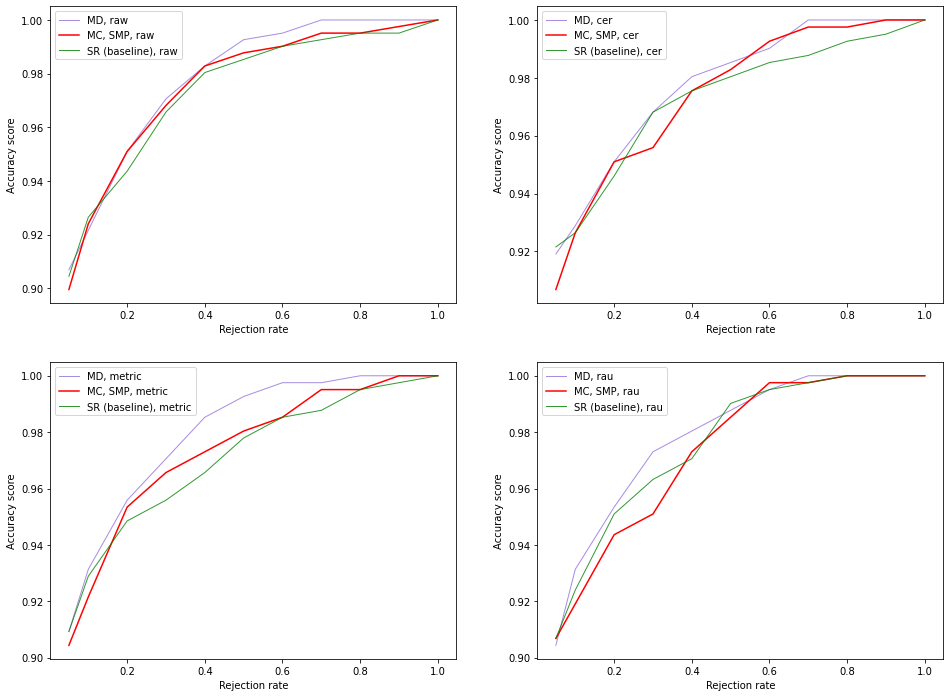

In [18]:
fig, axes = plt.subplots(2,2, figsize=(16,12))
for idx, postfix in enumerate(postfixes):
    maha_scores = prepare_probas_maha(os.path.join(config.output_dir, postfix, "maha"))
    mc_scores = prepare_probas_mc(os.path.join(config.output_dir, postfix, "mc"))
    sr_scores = prepare_probas_sr(os.path.join(config.output_dir, postfix, "mc"))
    axes[idx // 2][idx % 2].plot(ratio_list, maha_scores, label=f'MD, {postfix}', linewidth=1,  c='mediumpurple', alpha=0.8)
    axes[idx // 2][idx % 2].plot(ratio_list, mc_scores, label=f'MC, SMP, {postfix}', linewidth=1.5, c='r')
    axes[idx // 2][idx % 2].plot(ratio_list, sr_scores, label=f"SR (baseline), {postfix}", linewidth=1, c='g', alpha=0.8)
    axes[idx // 2][idx % 2].set_ylabel("Accuracy score", fontdict={"size": 10})
    axes[idx // 2][idx % 2].set_xlabel("Rejection rate", fontdict={"size": 10})
    axes[idx // 2][idx % 2].legend()

Again, we can see that Mahalanobis distance with metric loss shows the best results.